# Data analysis books for UBike services
We require to install **pandas**, **metplotlib** and **seaborn** in the virtual environment. 


In [14]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import display

#pd.set_option('display.max_rows',30)
#pd.set_option('large_repr', 'info')

# read data here
bikecsv = pd.read_csv('data/youbike_240518.csv') 

bikecsv

,_id,station_no,station_name,station_name_en,district,district_en,total,rentAvailable,returnAvaiable,updated_time,info_time
0,66477f00ffd73e577b8e8ee9,500101001,YouBike2.0_捷運科技大樓站,YouBike2.0_MRT Technology Bldg. Sta.,大安區,Daan Dist.,28,2,26,2024-05-17 23:58:23,2024-05-18 00:00:00
1,66477f00ffd73e577b8e8eea,500101002,YouBike2.0_復興南路二段273號前,YouBike2.0_No.273， Sec. 2， Fuxing S. Rd.,大安區,Daan Dist.,21,4,17,2024-05-17 23:58:23,2024-05-18 00:00:00
2,66477f00ffd73e577b8e8eeb,500101003,YouBike2.0_國北教大實小東側門,YouBike2.0_NTUE Experiment Elementary School (...,大安區,Daan Dist.,16,10,6,2024-05-17 23:58:23,2024-05-18 00:00:00
3,66477f00ffd73e577b8e8eec,500101004,YouBike2.0_和平公園東側,YouBike2.0_Heping Park (East),大安區,Daan Dist.,11,3,8,2024-05-17 23:58:23,2024-05-18 00:00:00
4,66477f00ffd73e577b8e8eed,500101005,YouBike2.0_辛亥復興路口西北側,YouBike2.0_Xinhai Fuxing Rd. Intersection (Nor...,大安區,Daan Dist.,16,4,12,2024-05-17 23:58:23,2024-05-18 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...
407025,6648cf54ffd73e577b94c5f9,500119087,YouBike2.0_臺大總圖書館西南側,YouBike2.0_NTU Main Library(Southwest),臺大公館校區,NTU Dist,30,0,30,2024-05-18 23:53:24,2024-05-18 23:55:00
407026,6648cf54ffd73e577b94c5fa,500119088,YouBike2.0_臺大黑森林西側,YouBike2.0_NTU Black Forest(West),臺大公館校區,NTU Dist,20,0,20,2024-05-18 23:53:24,2024-05-18 23:55:00
407027,6648cf54ffd73e577b94c5fb,500119089,YouBike2.0_臺大獸醫館南側,YouBike2.0_NTU Dept. of Veterinary Medicine(So...,臺大公館校區,NTU Dist,24,0,24,2024-05-18 23:53:24,2024-05-18 23:55:00
407028,6648cf54ffd73e577b94c5fc,500119090,YouBike2.0_臺大新體育館東南側,YouBike2.0_NTU Sports Center(Southeast),臺大公館校區,NTU Dist,40,0,40,2024-05-18 23:53:24,2024-05-18 23:55:00


## Before analyses, it requires us to know columns in csv data

**Here is the table show meaning or types of data.**

| Column Name | Type (Numerical/Category) | nullable | description |
| --- | --- | --- | --- |
| _id | Categorical | non-null | uuid generated by mongoDB also serial id |  
| station_no | Categorical | non-null | Serial Number |  
| station_name | Categorical | non-null | Station name |  
| district | Categorical | non-null | stations in which districts |  
| total | Numerical |  non-null | total = used + empty| 
| rentAvailable | Numerical |  non-null | available rental seats in stations | 
| returnAvaiable | Numerical |  non-null | avaiable return seats in stations | 
| updated_time | Date String | non-null | date time string in TZ GMT+8 |
|info_time | Date String | non-null | date time string in TZ GMT+8 |

Also, `info_time` can be categorize as workday or weekend to analyse 

## After Identify meanings of data columns, Here is a check list to process the dataframe

In [15]:
import ipywidgets as widgets

cb1 = widgets.Checkbox(description="define the outliers according to description of columns")
cb2 = widgets.Checkbox(description="define the error data in csv and remove them")
cb3 = widgets.Checkbox(description="process date string with pandas")
cb4 = widgets.Checkbox(description="Drop Some serial ID columns")

pb = widgets.Button(
    description='Click me',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click me',
)

def on_button_clicked(b):
    print("clicked on:",b)
    print("cb1:", cb1.value)
    print("cb2:", cb2.value)
    print("cb3:", cb3.value)
    print("cb4:", cb4.value)

pb.on_click(on_button_clicked)

ui = widgets.VBox([widgets.VBox([cb1, cb2, cb3, cb4]),pb])

display(ui)

In [16]:
print('In the Step: we are going to drop serial columns')
# drop column here axis=0 indicates data in row, axis=1 indicates data in column
bikecsv = bikecsv.drop(axis=1, columns=['_id', 'station_no','station_name','district'])
bikecsv

In the Step: we are going to drop serial columns


,station_name_en,district_en,total,rentAvailable,returnAvaiable,updated_time,info_time
0,YouBike2.0_MRT Technology Bldg. Sta.,Daan Dist.,28,2,26,2024-05-17 23:58:23,2024-05-18 00:00:00
1,YouBike2.0_No.273， Sec. 2， Fuxing S. Rd.,Daan Dist.,21,4,17,2024-05-17 23:58:23,2024-05-18 00:00:00
2,YouBike2.0_NTUE Experiment Elementary School (...,Daan Dist.,16,10,6,2024-05-17 23:58:23,2024-05-18 00:00:00
3,YouBike2.0_Heping Park (East),Daan Dist.,11,3,8,2024-05-17 23:58:23,2024-05-18 00:00:00
4,YouBike2.0_Xinhai Fuxing Rd. Intersection (Nor...,Daan Dist.,16,4,12,2024-05-17 23:58:23,2024-05-18 00:00:00
...,...,...,...,...,...,...,...
407025,YouBike2.0_NTU Main Library(Southwest),NTU Dist,30,0,30,2024-05-18 23:53:24,2024-05-18 23:55:00
407026,YouBike2.0_NTU Black Forest(West),NTU Dist,20,0,20,2024-05-18 23:53:24,2024-05-18 23:55:00
407027,YouBike2.0_NTU Dept. of Veterinary Medicine(So...,NTU Dist,24,0,24,2024-05-18 23:53:24,2024-05-18 23:55:00
407028,YouBike2.0_NTU Sports Center(Southeast),NTU Dist,40,0,40,2024-05-18 23:53:24,2024-05-18 23:55:00


In [17]:
print('In the Step: we are going to drop error data')

filtered = bikecsv.loc[bikecsv['total'] == bikecsv['rentAvailable']+bikecsv['returnAvaiable'],:]

print('Correct data Percentage: '+str(round(len(filtered)/len(bikecsv),4) * 100)+'%')


In the Step: we are going to drop error data
Correct data Percentage: 87.78%


In [18]:
print('Let\'s show some insight of date')

## convert datetime strings to datetime formats
filtered['info_time'] = pd.to_datetime(filtered['info_time'],format='%Y-%m-%d %H:%M:%S')
filtered['updated_time'] = pd.to_datetime(filtered['updated_time'],format='%Y-%m-%d %H:%M:%S')

## calculate time difference between station updated time and current time
timeDiff = (filtered['info_time'] - filtered['updated_time']) / pd.Timedelta(minutes=1)

filtered['TimeDiff'] = timeDiff

Let's show some insight of date


/var/folders/gw/xs4027fs03d38xr930y9wywm0000gn/T/ipykernel_90450/377676377.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered['info_time'] = pd.to_datetime(filtered['info_time'],format='%Y-%m-%d %H:%M:%S')
/var/folders/gw/xs4027fs03d38xr930y9wywm0000gn/T/ipykernel_90450/377676377.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered['updated_time'] = pd.to_datetime(filtered['updated_time'],format='%Y-%m-%d %H:%M:%S')


In [20]:
## judge if current time is workday or not
def isWorkHour (timeSeries):
    work_day = timeSeries.weekday() < 5
    work_hour = timeSeries.hour >= 8 & timeSeries.hour < 19
    return work_day & work_hour

workday = filtered['info_time'].apply(isWorkHour)

filtered['isWorkDay'] = workday

/var/folders/gw/xs4027fs03d38xr930y9wywm0000gn/T/ipykernel_90450/1290639516.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered['isWorkDay'] = workday


,station_name_en,district_en,total,rentAvailable,returnAvaiable,updated_time,info_time,TimeDiff,isWorkDay
0,YouBike2.0_MRT Technology Bldg. Sta.,Daan Dist.,28,2,26,2024-05-17 23:58:23,2024-05-18 00:00:00,1.616667,False
1,YouBike2.0_No.273， Sec. 2， Fuxing S. Rd.,Daan Dist.,21,4,17,2024-05-17 23:58:23,2024-05-18 00:00:00,1.616667,False
2,YouBike2.0_NTUE Experiment Elementary School (...,Daan Dist.,16,10,6,2024-05-17 23:58:23,2024-05-18 00:00:00,1.616667,False
3,YouBike2.0_Heping Park (East),Daan Dist.,11,3,8,2024-05-17 23:58:23,2024-05-18 00:00:00,1.616667,False
4,YouBike2.0_Xinhai Fuxing Rd. Intersection (Nor...,Daan Dist.,16,4,12,2024-05-17 23:58:23,2024-05-18 00:00:00,1.616667,False
...,...,...,...,...,...,...,...,...,...
407025,YouBike2.0_NTU Main Library(Southwest),NTU Dist,30,0,30,2024-05-18 23:53:24,2024-05-18 23:55:00,1.600000,False
407026,YouBike2.0_NTU Black Forest(West),NTU Dist,20,0,20,2024-05-18 23:53:24,2024-05-18 23:55:00,1.600000,False
407027,YouBike2.0_NTU Dept. of Veterinary Medicine(So...,NTU Dist,24,0,24,2024-05-18 23:53:24,2024-05-18 23:55:00,1.600000,False
407028,YouBike2.0_NTU Sports Center(Southeast),NTU Dist,40,0,40,2024-05-18 23:53:24,2024-05-18 23:55:00,1.600000,False


In [21]:
## Add ratio between rentAvailable and total
filtered['ratio'] = filtered['rentAvailable'] / filtered['total'] * 100

filtered

/var/folders/gw/xs4027fs03d38xr930y9wywm0000gn/T/ipykernel_90450/1613316239.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered['ratio'] = filtered['rentAvailable'] / filtered['total'] * 100


,station_name_en,district_en,total,rentAvailable,returnAvaiable,updated_time,info_time,TimeDiff,isWorkDay,ratio
0,YouBike2.0_MRT Technology Bldg. Sta.,Daan Dist.,28,2,26,2024-05-17 23:58:23,2024-05-18 00:00:00,1.616667,False,7.142857
1,YouBike2.0_No.273， Sec. 2， Fuxing S. Rd.,Daan Dist.,21,4,17,2024-05-17 23:58:23,2024-05-18 00:00:00,1.616667,False,19.047619
2,YouBike2.0_NTUE Experiment Elementary School (...,Daan Dist.,16,10,6,2024-05-17 23:58:23,2024-05-18 00:00:00,1.616667,False,62.500000
3,YouBike2.0_Heping Park (East),Daan Dist.,11,3,8,2024-05-17 23:58:23,2024-05-18 00:00:00,1.616667,False,27.272727
4,YouBike2.0_Xinhai Fuxing Rd. Intersection (Nor...,Daan Dist.,16,4,12,2024-05-17 23:58:23,2024-05-18 00:00:00,1.616667,False,25.000000
...,...,...,...,...,...,...,...,...,...,...
407025,YouBike2.0_NTU Main Library(Southwest),NTU Dist,30,0,30,2024-05-18 23:53:24,2024-05-18 23:55:00,1.600000,False,0.000000
407026,YouBike2.0_NTU Black Forest(West),NTU Dist,20,0,20,2024-05-18 23:53:24,2024-05-18 23:55:00,1.600000,False,0.000000
407027,YouBike2.0_NTU Dept. of Veterinary Medicine(So...,NTU Dist,24,0,24,2024-05-18 23:53:24,2024-05-18 23:55:00,1.600000,False,0.000000
407028,YouBike2.0_NTU Sports Center(Southeast),NTU Dist,40,0,40,2024-05-18 23:53:24,2024-05-18 23:55:00,1.600000,False,0.000000


In [33]:
groupByHourAndDistrict = filtered.groupby([filtered['info_time'].dt.hour, 'district_en'])

/var/folders/gw/xs4027fs03d38xr930y9wywm0000gn/T/ipykernel_90450/3905258553.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(grouped.columns))


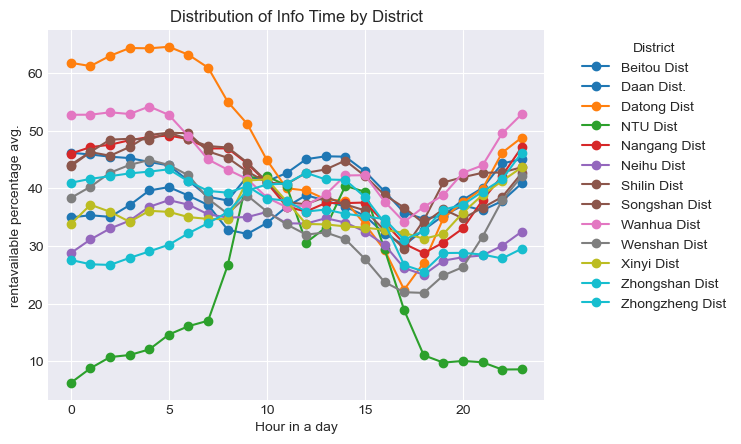

<Figure size 6400x3200 with 0 Axes>

In [34]:

# 按照 'district_en' 和 'info_time' 聚合
grouped = groupByHourAndDistrict['ratio'].mean().unstack()

colors = plt.cm.get_cmap('tab10', len(grouped.columns))

for i,area in enumerate(grouped.columns):
    plt.plot(grouped.index, grouped[area], marker='o', label=area, color=colors(i))

plt.title('Distribution of Info Time by District')
plt.xlabel('Hour in a day')
plt.ylabel('rentavailable percentage avg.')
plt.legend(title='District', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.figure(figsize=(64, 32))
plt.show()

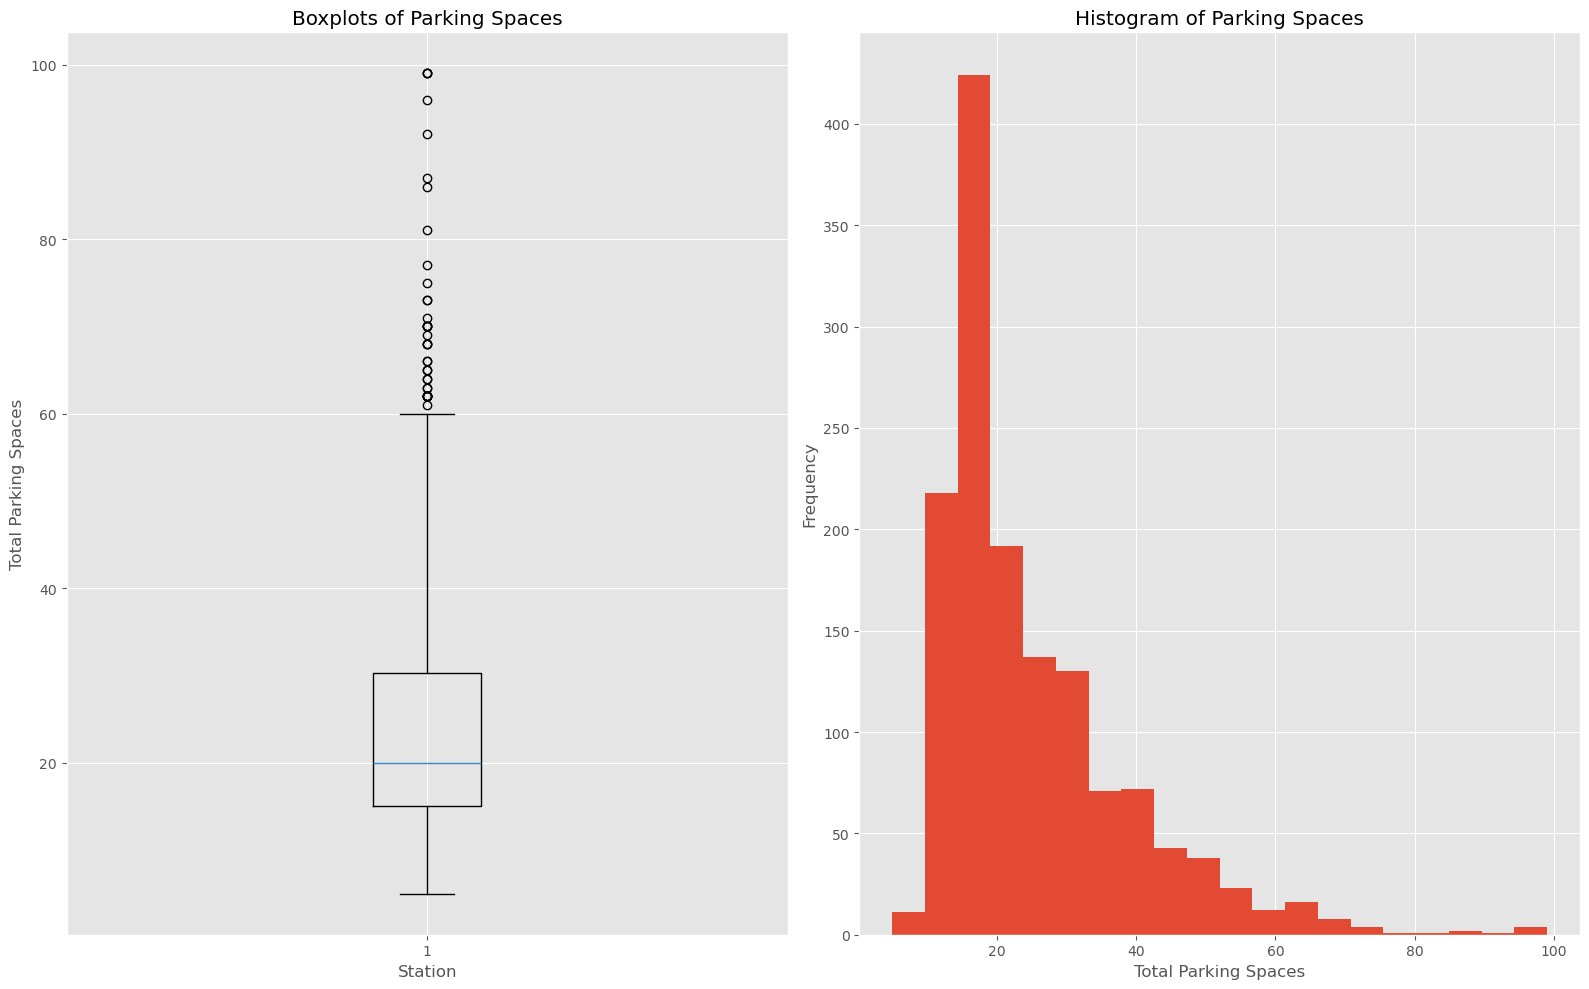

In [ ]:
groupByStation = bikecsv.groupby(['station_name_en'], as_index=False)

dataframe = groupByStation['total'].max().sort_values(by='total',ascending=True)

parkinglots = dataframe['total']

plt.style.use('ggplot')
fig = plt.figure('Parking distribution',figsize=(16,10))
# 創建並排的子圖
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

ax1.boxplot(parkinglots,whis=2)
ax1.set_title('Boxplots of Parking Spaces')
ax1.set_xlabel('Station')
ax1.set_ylabel('Total Parking Spaces')

ax2.hist(parkinglots, bins=20)
ax2.set_title('Histogram of Parking Spaces')
ax2.set_xlabel('Total Parking Spaces')
ax2.set_ylabel('Frequency')


plt.tight_layout()
plt.show()

**According to the boxplots and histogram, total number of parking space is a determin factor to distribution.**

These illustrate most of stations with 15 parking lots. Also, we could divid into 4 sections to inspect the difference of average usage rates. 

In [ ]:
parkinglots.describe()

count    1408.000000
mean       24.880682
std        13.705553
min         5.000000
25%        15.000000
50%        20.000000
75%        30.250000
max        99.000000
Name: total, dtype: float64

In [25]:
qtrBikecsv = filtered.copy()
# get qcut bins based on descriptions of parkinglots 
qcuts = pd.cut(qtrBikecsv['total'], bins=[0,15,20,30,60,99], labels=['Q1','Q2','Q3','Q4','Outlier'])

qtrBikecsv = pd.concat((qtrBikecsv, qcuts.rename('range')),axis=1)

qtrBikecsv


,station_name_en,district_en,total,rentAvailable,returnAvaiable,updated_time,info_time,TimeDiff,isWorkDay,ratio,range
0,YouBike2.0_MRT Technology Bldg. Sta.,Daan Dist.,28,2,26,2024-05-17 23:58:23,2024-05-18 00:00:00,1.616667,False,7.142857,Q3
1,YouBike2.0_No.273， Sec. 2， Fuxing S. Rd.,Daan Dist.,21,4,17,2024-05-17 23:58:23,2024-05-18 00:00:00,1.616667,False,19.047619,Q3
2,YouBike2.0_NTUE Experiment Elementary School (...,Daan Dist.,16,10,6,2024-05-17 23:58:23,2024-05-18 00:00:00,1.616667,False,62.500000,Q2
3,YouBike2.0_Heping Park (East),Daan Dist.,11,3,8,2024-05-17 23:58:23,2024-05-18 00:00:00,1.616667,False,27.272727,Q1
4,YouBike2.0_Xinhai Fuxing Rd. Intersection (Nor...,Daan Dist.,16,4,12,2024-05-17 23:58:23,2024-05-18 00:00:00,1.616667,False,25.000000,Q2
...,...,...,...,...,...,...,...,...,...,...,...
407025,YouBike2.0_NTU Main Library(Southwest),NTU Dist,30,0,30,2024-05-18 23:53:24,2024-05-18 23:55:00,1.600000,False,0.000000,Q3
407026,YouBike2.0_NTU Black Forest(West),NTU Dist,20,0,20,2024-05-18 23:53:24,2024-05-18 23:55:00,1.600000,False,0.000000,Q2
407027,YouBike2.0_NTU Dept. of Veterinary Medicine(So...,NTU Dist,24,0,24,2024-05-18 23:53:24,2024-05-18 23:55:00,1.600000,False,0.000000,Q3
407028,YouBike2.0_NTU Sports Center(Southeast),NTU Dist,40,0,40,2024-05-18 23:53:24,2024-05-18 23:55:00,1.600000,False,0.000000,Q4


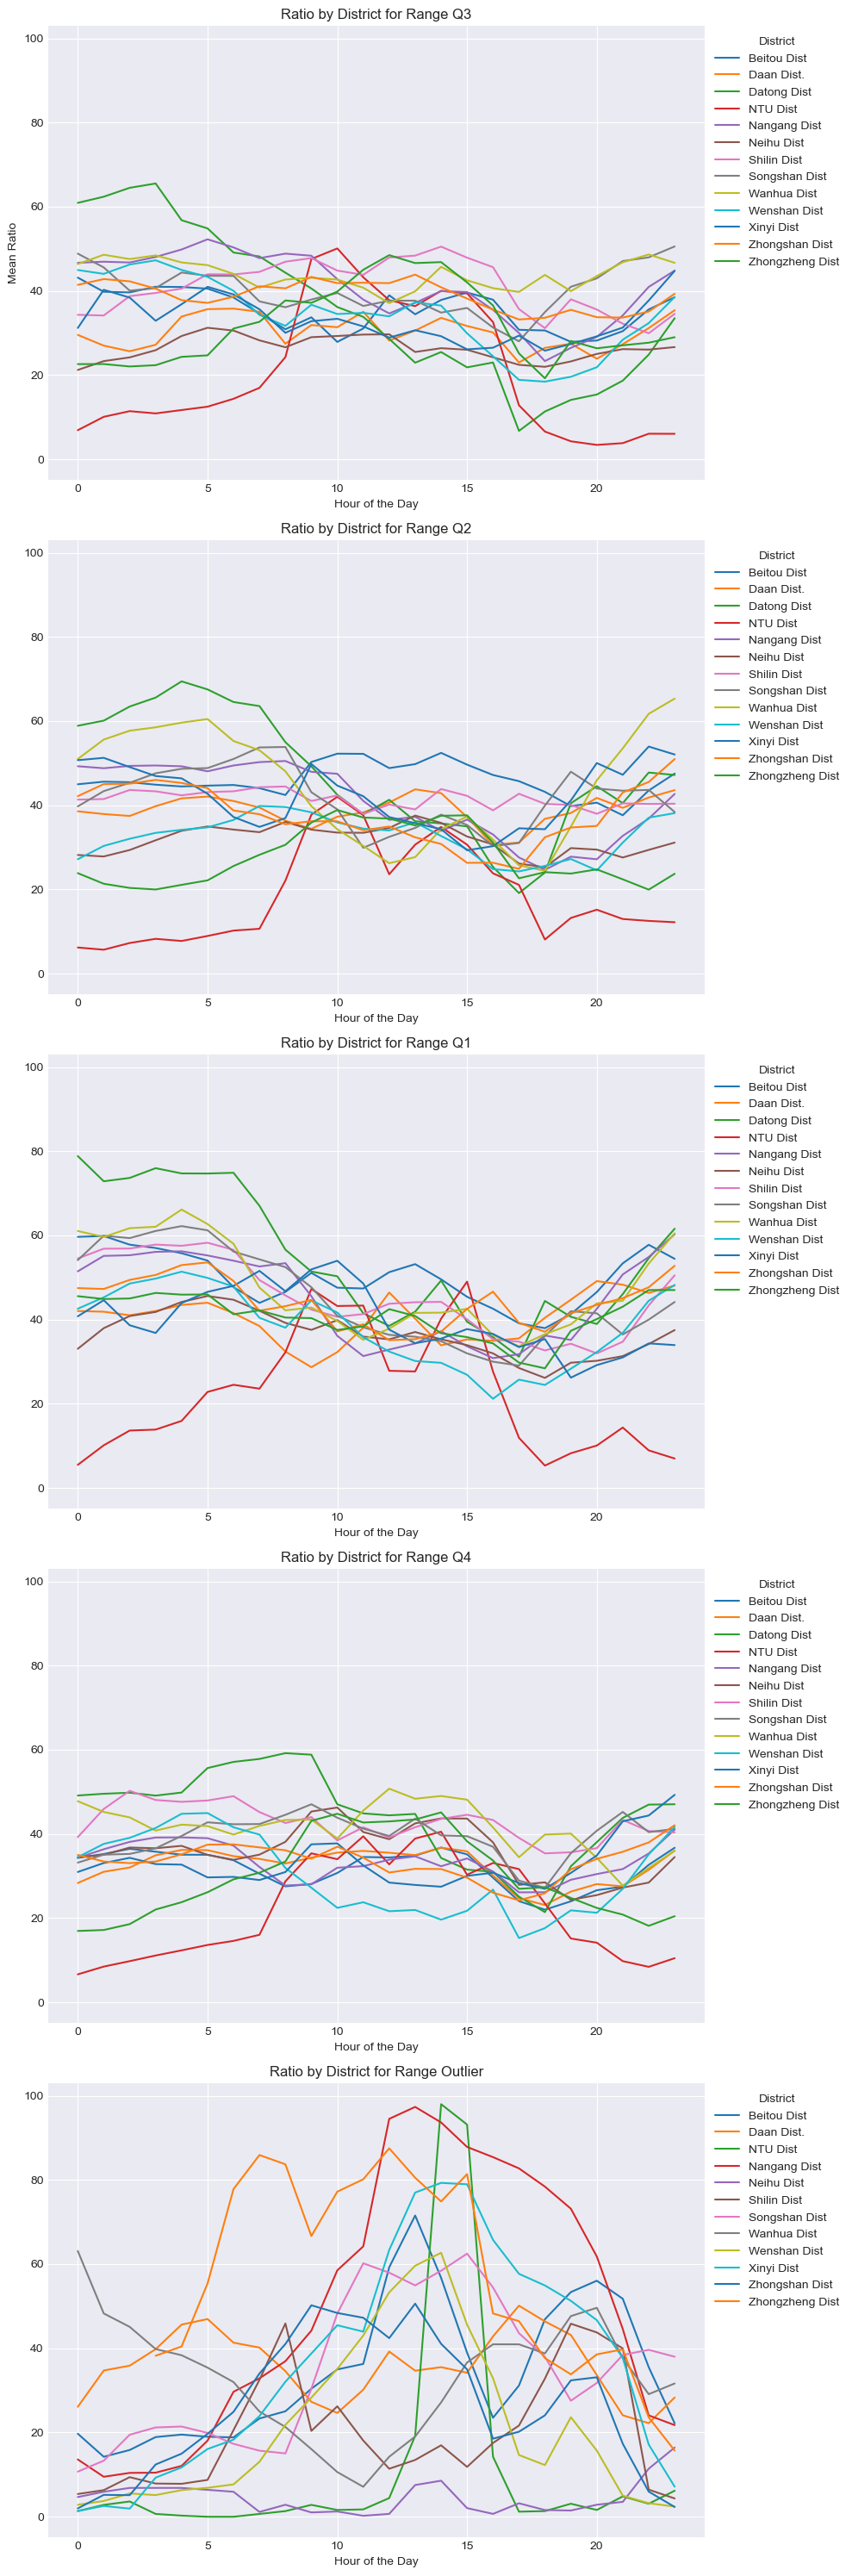

In [49]:
# 使用 matplotlib 庫設置圖表樣式
plt.style.use('seaborn-v0_8-darkgrid')

# 獲取 'range' 列的唯一值
uniq_ranges = qtrBikecsv['range'].unique()

# 設置子圖的行列數
num_rows = len(uniq_ranges)
num_cols = 1  # 一列只有一張圖表

# 創建子圖
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 6*num_rows),sharey=True)

# 逐個處理每個唯一值
for i, uniq in enumerate(uniq_ranges):
    # 根據 'range' 分組
    groupQtrDist = qtrBikecsv.loc[qtrBikecsv['range'] == uniq, :].groupby([ qtrBikecsv['info_time'].dt.hour,'district_en'])
        
    # 計算每個分組的平均值，並將 'info_time' 時間的層次解除堆疊
    pivot_table = groupQtrDist['ratio'].mean().unstack()
    # 繪製折線圖
    pivot_table.plot(kind='line', ax=axes[i])
    
    # 設置圖表標題和軸標籤
    axes[i].set_title(f'Ratio by District for Range {uniq}')
    axes[i].set_xlabel('Hour of the Day')
    axes[i].set_ylabel('Mean Ratio' if i == 0 else "")  # 只在第一個子圖上顯示 Y 軸標籤        
    # 設置圖例
    axes[i].legend(title='District', bbox_to_anchor=(1, 1))

# 調整子圖之間的間距
plt.tight_layout()

# 顯示圖表
plt.show()